## BEE - The Spiking Liquid Simulator

# To implement this work in SpiNNaker I will need to change at least two things:
# 1 - The gaussian weighted inputs must follow something like presented in Oliveri's paper
# 2 - The zero mean gaussian random offset current will have to be changed to something else. Maybe an external population randomly sending spikes to all the liquid...

In [ ]:
# I could verify the differences between differents connection pattern input=>liquid and
# also for liquid=>output

In [30]:
# This is not working on Linux because I'm getting an error whilst compiling the shared library 
import sys
from BEE import *

In [31]:
# Makes possible to show the output from matplotlib inline
%matplotlib inline
import matplotlib.pyplot as plt

from matplotlib  import cm
import scipy.ndimage

import matplotlib as mpl

    
# Makes the figures in the PNG format:
# For more information see %config InlineBackend
%config InlineBackend.figure_formats=set([u'png'])

# plt.rcParams['figure.figsize'] = 5, 10

import numpy
import sys
import os
import time

import save_load_file as slf

# Generates the input converter

In [51]:
def generates_connections(liqseeds, lsm_i, neuron_params, connection_type='2D', net_shape = numpy.array([20,5,6])):
    
    disconnected,membrane_rand,current_rand,noisy_current_rand,SpkLiq_vresets_rand,lbd_value,parameter_list=neuron_params

    #
    # Liquid's shape
    #

    # Liquid's shape
    # net_shape = numpy.array([20,5,6])

    # Random seeds:
    # // RANDOM-1: Noisy offset currents / resets
    # // RANDOM-2: Selection of the inhibitory and excitatory neurons
    # // RANDOM-3: Internal connections of the liquid
    RANDOM_1=liqseeds[lsm_i][1]
    RANDOM_2=liqseeds[lsm_i][2]
    RANDOM_3=liqseeds[lsm_i][3]
    #DEBUG!
    # RANDOM_4=liqseeds[lsm_i][4]
    # RANDOM_0=liqseeds[lsm_i][0]

    input_noise_std = 1 # Standard deviation of the input gaussian noise

    # Neuron parameters
    taum=0.03 # membrane time constant
    cm=3e-08 # membrane capacitance
    taue=0.003 # excitatory synapse time constant
    taui=0.006 # inhibitory synapse time constant


    
    input_gain=105. # gain used for the input neurons
    w_SD = 3.0 # input neurons standard deviation


    #
    # END OF THE SETUP - everything that should change between liquids is expressed above...
    #


    #
    # This first initialization of the simulator is only used to generate the liquid structure's data
    #

    # Resets the simulator
    BEE_free()

    tstp = time_step

    seeds=numpy.array(numpy.random.randint(0,10000,5),dtype=numpy.uint32)
    # // RANDOM-0: Membrane initial potentials
    # // RANDOM-1: Noisy offset currents / resets
    # // RANDOM-2: Selection of the inhibitory and excitatory neurons
    # // RANDOM-3: Internal connections of the liquid
    # // RANDOM-4: Noisy corrents
    seeds[1] = RANDOM_1
    seeds[2] = RANDOM_2
    seeds[3] = RANDOM_3
    # Only initial membrane and noisy currents are kept truly random without any seed


    if not BEE_initialized():
        initialize_sim(my_net_shape = net_shape, \
                       my_lbd_value = lbd_value, \
                       my_seeds=seeds, \
                       SpkLiq_step=time_step,\
                       SpkLiq_threads_N = 5,\
                       SpkLiq_vresets = SpkLiq_vresets_rand,\
                       SpkLiq_membrane_rand=membrane_rand,\
                       SpkLiq_current_rand=current_rand,\
                       SpkLiq_taum=taum, SpkLiq_cm=cm, SpkLiq_taue=taue, SpkLiq_taui=taui, \
                       SpkLiq_noisy_current_rand=noisy_current_rand)


    if parameter_list!=[]:
        change_parameters(parameter_list)

    if BEE_initialized() and (not BEE_connected()):
        generate_connections()

    #
    # Cancels the connections, but keeps the parameters
    #
    if disconnected:
        BEE_writes_SpkLiq_inh_connections(0)
        BEE_writes_SpkLiq_exc_connections(0)

    if BEE_initialized() and (not BEE_connected()):
        process_connections()

    NofN,NoINHN,NoEXCN,NoINHC,NoEXCC=output_stats(stats=0)

    # Normally the BEE simulator does NOT updates neurons that have no connections to other neurons.
    # The neurons without connections are marked in a special array that can be read from the
    # Python function output_connected(NofN).
    # Every time the simulator goes through one step it checks if the neurons is marked as connected before
    # updating its state variables.

    # Disconnects all the neurons (nothing will generate spikes anymore)
    # control_connected(numpy.zeros(NofN,dtype=numpy.int32))

    # Forces the simulator to calculate the values for all neurons (even the unconnected ones)
    # This is important during the tests without connections
    control_connected(numpy.ones(NofN,dtype=numpy.int32))


    #
    # Input converter
    # 

    # This information is used to define the neurons receiving inputs (excitatory neurons):
    inhibitory_index_L = output_inh_indices(NoINHN)
    inhibitory_index_L.shape

    inhibitory_index_L=[] # input signals through all neurons (not only excitatory ones)

    #
    # Input pattern generation
    # 

    Number_of_neurons_lsm = NofN
    Number_of_input_layers = Number_of_input_variables
    Number_of_neurons_inputs = Ninput

    # This is how the liquid neurons index are distributed inside the 3D shape
    count_3d=0;

    # Neuron index to XYZ: Each line is a neuron index and the collumns are its x,y and z positions.
    Neuron3DMatrix = numpy.zeros((NofN,3),dtype=numpy.int)

    # XYZ to neuron index: According to the X,Y,Z gives the neuron index
    Neuron3DMatrixXYZ = numpy.zeros(net_shape,dtype=numpy.int)

    # Fill the Neuron3DMatrix and Neuron3DMatrixXYZ arrays
    for zi in range(net_shape[2]):
        for yi in range(net_shape[1]):
            for xi in range(net_shape[0]):
                Neuron3DMatrix[count_3d][0]=xi;
                Neuron3DMatrix[count_3d][1]=yi;
                Neuron3DMatrix[count_3d][2]=zi;
                Neuron3DMatrixXYZ[xi,yi,zi]=count_3d
                count_3d+=1;
    
    if connection_type=='2D':

        # 
        # 2D Gaussian generation
        #

        #
        # Generates the connection pattern used. In the case below it's a gaussian 
        # distributed one based on the connection weights.
        #

        # In order to use SpiNNaker I should change from weight based to spike based (like in Oliveri's article).

        inputs_indices = [] #inputs_indices[input_variable][ni]
        inputs_weights = [] #inputs_weights[input_variable][ni]


        def gaussian(lamb,n,nt):
            '''
            Generates a gaussian centered at 'n'
            '''
            return input_gain*numpy.exp(-((nt-n)**2)/(2*(lamb)**2)) #No energy normalization

        weight_func = gaussian


        liquid_input_layer_size = int(Number_of_neurons_lsm/float(Number_of_input_layers))

        # Goes through the liquid to generate the proper connections, 
        # but dividing the liquid into the same number of input layers.
        # Each input layer only connects to its own slice of the liquid.

        centre_positions=numpy.linspace(0,liquid_input_layer_size-1,num=Number_of_neurons_inputs).astype(dtype=numpy.int)

        for inp in range(Number_of_input_layers): #goes through the input layers
            temp_i=[]
            temp_w=[]        
            for i,ic in zip(range(inp*Number_of_neurons_inputs,Number_of_neurons_inputs*(inp+1)),\
                            range(Number_of_neurons_inputs)): #goes through the input neurons
                temp_i2 = []
                temp_w2 = []
                for j,ji in zip(range(inp*liquid_input_layer_size,liquid_input_layer_size*(inp+1)),\
                                range(liquid_input_layer_size)):
                    if j not in inhibitory_index_L:
                        centre_position=centre_positions[ic]
                        temp_weight=weight_func(w_SD,centre_position,ji)             
                        if temp_weight>0: #guaranties only real spikes will be injected, saving cpu time
                            temp_w2.append(temp_weight) # in nA
                            temp_i2.append(j) # i=>input's neuron; j=>liquid's neuron                                        
                temp_i.append(temp_i2)
                temp_w.append(temp_w2)
            inputs_indices.append(temp_i)
            inputs_weights.append(temp_w)

    if connection_type=='3D':        
        # Each input variable will be injected in one layer (Z).
        # The layers are a rectangle with size X*Y.
        # The weights will be distributed on this plane (X,Y), initially as a 3D Gaussian.

        # I want to be able to select which layer a variable is going to use. THIS CAN BE DONE LATER, NOT HERE.
        inputs_indices = [] #inputs_indices[input_variable][ni]
        inputs_weights = [] #inputs_weights[input_variable][ni]


        def gaussian3d(lamb,ux,ntx,uy,nty):
            '''
            Generates a gaussian centered at '(ux,uy)'
            http://mathworld.wolfram.com/GaussianFunction.html
            '''
            return input_gain*numpy.exp(-((ntx-ux)**2+(nty-uy)**2)/(2*(lamb)**2)) #No energy normalization


        liquid_input_layer_size = int(Number_of_neurons_lsm/float(Number_of_input_layers))

        # divides the input layer into Ninput indices
        centre_positions=numpy.linspace(0,liquid_input_layer_size-1,num=Number_of_neurons_inputs).astype(dtype=numpy.int)

        for inp in range(Number_of_input_layers): #goes through the input layers (the liquid's Z index)
            temp_i=[]
            temp_w=[]        
            for i,ic in zip(range(inp*Number_of_neurons_inputs,Number_of_neurons_inputs*(inp+1)),\
                            range(Number_of_neurons_inputs)): #goes through the input neurons
                temp_i2 = []
                temp_w2 = []
                for yi in range(net_shape[1]):
                    for xi in range(net_shape[0]):
                        j=Neuron3DMatrixXYZ[xi,yi,inp] # j=>liquid's neuron (post-synaptic)
                        # If only the excitatory are used, the curve doesn't look like a Gaussian because has holes!
                        if j not in inhibitory_index_L:
                            temp_i2.append(j) # i=>input's neuron; j=>liquid's neuron
                            ux,uy,_=Neuron3DMatrix[centre_positions[ic]]
                            temp_w2.append(gaussian3d(w_SD,float(ux),float(xi),float(uy),float(yi))) # in nA
                temp_i.append(temp_i2)
                temp_w.append(temp_w2)
            inputs_indices.append(temp_i)
            inputs_weights.append(temp_w)

        slf.save_to_file(inputs_indices,"inputs_indices.pickle")
        slf.save_to_file(inputs_weights,"inputs_weights.pickle")
        
    if connection_type=='2DS':
        # Converts the neuron index distribution into the 3D shape according to the old system
        # Generates the connection pattern used. In the case below it's a gaussian 
        # distributed one based on the connection weights.

        # In order to use SpiNNaker I should change from weight based to spike based (like in Oliveri's article).
        normal_connections = True

        inputs_indices = [] #inputs_indices[input_variable][ni]
        inputs_weights = [] #inputs_weights[input_variable][ni]


        def gaussian(lamb,n,nt):
            '''
            Generates a gaussian centered at 'n'
            '''
            return input_gain*numpy.exp(-((nt-n)**2)/(2*(lamb)**2)) #No energy normalization

        weight_func = gaussian


        liquid_input_layer_size = int(Number_of_neurons_lsm/float(Number_of_input_layers))

        # Goes through the liquid to generate the proper connections, 
        # but dividing the liquid into the same number of input layers.
        # Each input layer only connects to its own slice of the liquid.

        centre_positions=numpy.linspace(0,liquid_input_layer_size-1,num=Number_of_neurons_inputs).astype(dtype=numpy.int)
        if normal_connections:
            for inp in range(Number_of_input_layers): #goes through the input layers
                temp_i=[]
                temp_w=[]        
                for i,ic in zip(range(inp*Number_of_neurons_inputs,Number_of_neurons_inputs*(inp+1)),\
                                range(Number_of_neurons_inputs)): #goes through the input neurons
                    temp_i2 = []
                    temp_w2 = []
                    for j,ji in zip(range(inp*liquid_input_layer_size,liquid_input_layer_size*(inp+1)),\
                                    range(liquid_input_layer_size)):
                        if True: #j not in inhibitory_index_L:
                            temp_i2.append(j) # i=>input's neuron; j=>liquid's neuron
                            centre_position=centre_positions[ic]
                            temp_w2.append(weight_func(w_SD,centre_position,ji)) # in nA
                    temp_i.append(temp_i2)
                    temp_w.append(temp_w2)
                inputs_indices.append(temp_i)
                inputs_weights.append(temp_w)
        else:    
            # USING A RANDOM ARRAY INSTEAD OF ORDERED NEURON INDICES!
            random_indices = numpy.arange(Number_of_neurons_lsm,dtype=numpy.int)
            numpy.random.shuffle(random_indices)
            for inp in range(Number_of_input_layers): #goes through the input layers
                temp_i=[]
                temp_w=[]
                for i,ic in zip(range(inp*Number_of_neurons_inputs,Number_of_neurons_inputs*(inp+1)),\
                                range(Number_of_neurons_inputs)): #goes through the input neurons
                    temp_i2 = []
                    temp_w2 = []
                    for j,ji in zip(random_indices[inp*liquid_input_layer_size:liquid_input_layer_size*(inp+1)],\
                                    range(liquid_input_layer_size)):
                        if True: #j not in inhibitory_index_L:
                            temp_i2.append(j) # i=>input's neuron; j=>liquid's neuron
                            centre_position=centre_positions[ic]
                            temp_w2.append(weight_func(w_SD,centre_position,ji)) # in nA
                    temp_i.append(temp_i2)
                    temp_w.append(temp_w2)
                inputs_indices.append(temp_i)
                inputs_weights.append(temp_w)

        # Generates a 3D matrix with the neuron indices
        old_Neuron3DMatrixXYZ=((numpy.arange(NofN)).reshape((net_shape[0],net_shape[1],net_shape[2])))

        old_Neuron3DMatrix=numpy.zeros((NofN,3),dtype=numpy.int)

        # First generates a map neuron index => X,Y,Z
        for zi in range(net_shape[2]):
            for yi in range(net_shape[1]):
                for xi in range(net_shape[0]):
                    old_Neuron3DMatrix[old_Neuron3DMatrixXYZ[xi,yi,zi]]=[xi,yi,zi]

        indices = numpy.array(inputs_indices)
        for i in range(Number_of_input_layers):
            for j in range(Number_of_neurons_inputs):
                new_index=[]
                for ni in indices[i,j]:
                    X,Y,Z=old_Neuron3DMatrix[ni] # reads the X,Y,Z position of the neuron index ni
                    if Neuron3DMatrixXYZ[X,Y,Z] not in inhibitory_index_L:
                        new_index.append(Neuron3DMatrixXYZ[X,Y,Z]) # converts the X,Y,Z
                inputs_indices[i][j]=new_index

#         slf.save_to_file(inputs_indices,"inputs_indices.pickle")
#         slf.save_to_file(inputs_weights,"inputs_weights.pickle")        
        
    return (inputs_indices,inputs_weights,Neuron3DMatrix)

In [52]:
sim_set = "IJCNN_01" # basically is the name of the folder where the data is read/saved
base_dir = "BaxterArm_VREP_simulation_data"

In [53]:
# S0, S1, E1 and W1 are the Baxter's joint names
# Four joints => four input variables
Number_of_input_variables=4 # defines how the liquid is going to be divided to receive the inputs

In [54]:
#
# Number of neurons at each input layer (defines the INPUT resolution of the system)
#
# >>>>>>>>> It MUST be smaller or equal to (NofN/Number_of_input_variables) <<<<<<<<<<<
#
Ninput = 150

In [55]:
liqseeds = slf.load_from_file_gz("./"+base_dir+"/"+sim_set+"/"+"liqseeds.gzpickle")
number_of_liquids = len(liqseeds)
for i in range(number_of_liquids):
    print "Liquid %d:" % i, liqseeds[i]

Liquid 0: [6232 8718  814 1159 1765 7181]
Liquid 1: [  29  236 3704 5331 3596  848]
Liquid 2: [2635 6893 6930  844  627  780]
Liquid 3: [4693  214  132 3070 1139 4523]
Liquid 4: [6384 2478   89 8327 5817 2639]


In [56]:
# Parameters paper Joshi/Maass
membrane_rand=[13.5E-3,14.9E-3]
current_rand=[13.5E-09, 14.5E-09]
noisy_current_rand=1E-9

factor=2*10.0
# membrane_rand=[13.5E-3, 13.5E-03*(1+1/factor)]
# current_rand=numpy.array([13.5E-09, 13.5E-09*(1+1/factor)])
# noisy_current_rand=(1E-9/factor)

SpkLiq_vresets_rand=[13.8E-3,13.8E-3*(1+1/factor)] # the membrane reset values are drawn from a uniform distribution

lbd_value = 1.2

parameter_list=\
[[[0.1  ,  0.32 ,  0.144,  0.06 ,  -47.  ,  0.8],\
  [0.4  ,  0.25 ,  0.7  ,  0.02 ,  -47  ,  0.8]],\
 [[0.2  ,  0.05 ,  0.125,  1.2  ,  150  ,  0.8],\
  [0.3  ,  0.5  ,  1.1  ,  0.05 ,  70  ,  1.5]]]

# parameter_list = []

disconnected = 0

neuron_params = disconnected,\
                membrane_rand,\
                current_rand,\
                noisy_current_rand,\
                SpkLiq_vresets_rand,\
                lbd_value,\
                parameter_list

In [71]:
net_shape = numpy.array([20,5,6])
inputs_indices,inputs_weights,Neuron3DMatrix = generates_connections(liqseeds,0,neuron_params,connection_type='3D',net_shape=net_shape)

# Connection pattern visualization

In [72]:
Number_of_neurons_lsm = net_shape[0]*net_shape[1]*net_shape[2]
Number_of_input_layers = Number_of_input_variables
Number_of_neurons_inputs = Ninput
w_SD=3

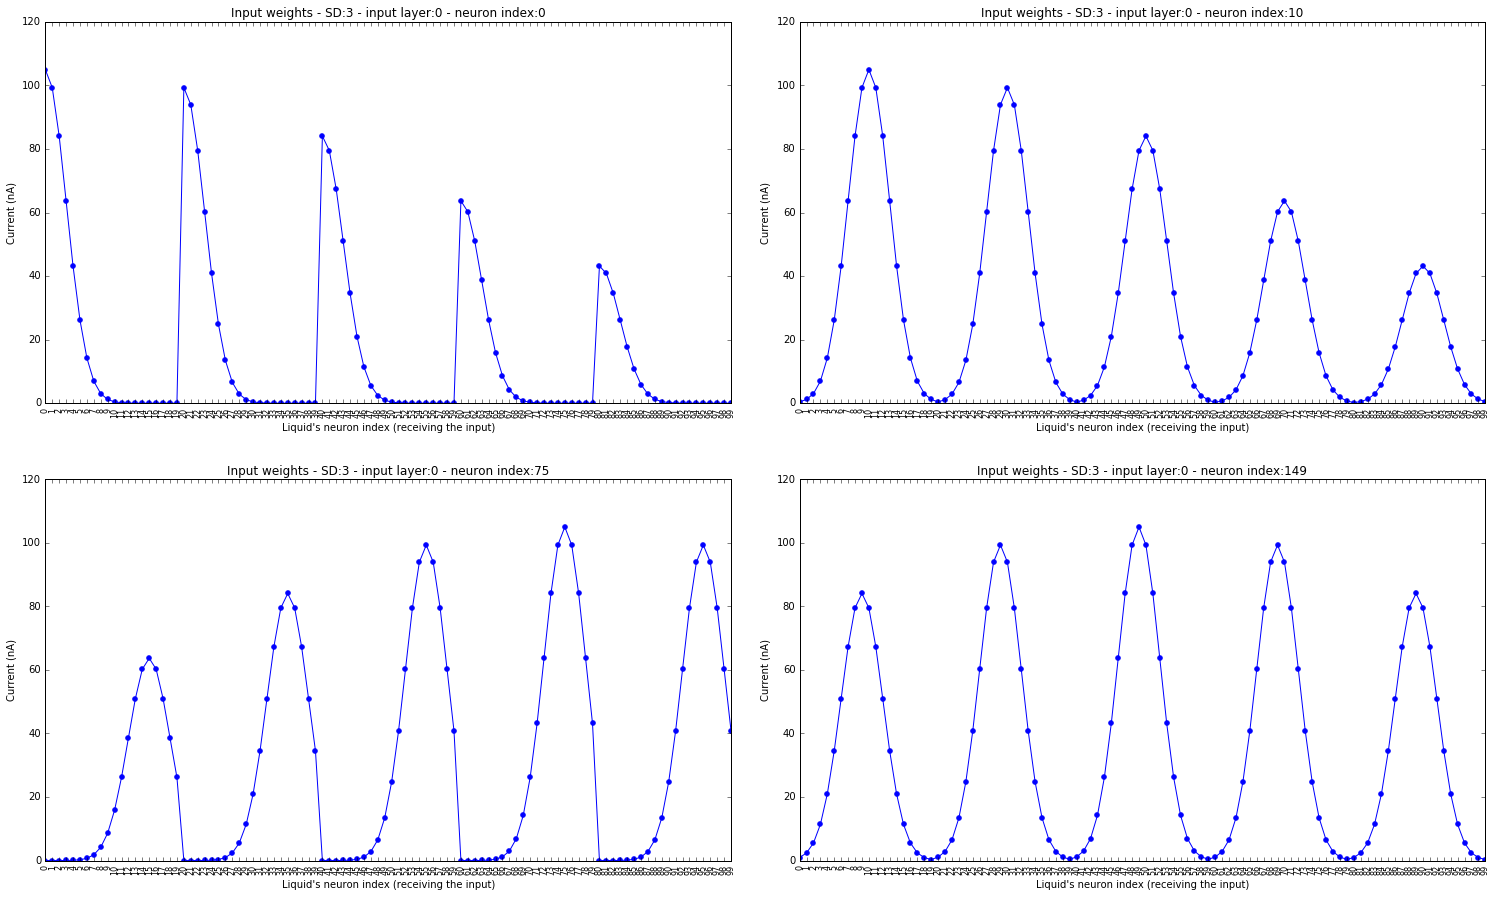

In [73]:
label_size = 8
mpl.rcParams['xtick.labelsize'] = label_size

# Visualizes how the weights are distributed
input_variable=0
neuron_indexs=[0,10,int(Number_of_neurons_inputs/2),Number_of_neurons_inputs-1]
plt.figure(figsize=(20,20))

for ni,i in zip(neuron_indexs,range(1,len(neuron_indexs)+1)):
    plt.subplot(3,2,i)
    neuron_index=0
#     plt.plot(numpy.array(inputs_indices[input_variable][ni])[:,1],inputs_weights[input_variable][ni],'.-',markersize=10)
    plt.plot(inputs_weights[input_variable][ni],'.-',markersize=10)    
    plt.title("Input weights - SD:"+str(w_SD)+" - input layer:"+str(input_variable)+" - neuron index:"+str(ni))
    plt.xlabel("Liquid's neuron index (receiving the input)")
    plt.ylabel("Current (nA)")
    plt.xticks(range(len(numpy.array(inputs_indices[input_variable][ni]))),numpy.array(inputs_indices[input_variable][ni]),rotation='vertical')
#     pltxmin,pltxmax=(numpy.array(inputs_indices[input_variable][ni])[:,1]).min(),(numpy.array(inputs_indices[input_variable][ni])[:,1]).max()
#     plt.xlim(pltxmin,pltxmax)
    plt.xlim(0,len(inputs_weights[input_variable][ni])-1)

plt.subplots_adjust(left=0, bottom=.1, right=1, top=1,wspace=.1, hspace=.2)
# plt.savefig("./"+base_dir+"/example_weights.pdf", bbox_inches='tight',pad_inches=1)    
plt.show()